# Task 2b: Traffic Sign Object Detection using YOLOv12

**Author:** Francesco  
**Architecture:** YOLOv12 (Ultralytics)  
**Framework:** PyTorch/Ultralytics  
**Dataset:** COCO Format converted to YOLO Format  

## Step 1: Configuration and Imports

Setup configuration class and import required libraries. 
**Critical:** Checks Ultralytics version for YOLOv12 compatibility (requires >= 8.3.40).

In [ ]:
import os
os.environ['ULTRALYTICS_DISABLE_ANALYTICS'] = '1'


import json
import yaml
import shutil
import warnings
from pathlib import Path
from collections import defaultdict
from typing import Dict, List
from packaging import version 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

try:
    from ultralytics import YOLO
    import ultralytics
    print(f"Ultralytics version: {ultralytics.__version__}")
    
    if version.parse(ultralytics.__version__) < version.parse("8.3.40"):
        print("WARNING: Upgrade ultralytics for YOLOv12 support:")
        print("   pip install --upgrade ultralytics")
except ImportError:
    raise ImportError("pip install --upgrade ultralytics")

import torch
warnings.filterwarnings('ignore')
%matplotlib inline


class Config:
    """Configuration for YOLOv12 Object Detection"""
    DataRoot = "signs_coco"
    AnnotationsFile = "signs_coco/result.json"
    YoloOutputDir = "data/yolo_detection"
    OutputDir = "outputs/yolo_detection"
    RunsDir = "runs/detect"
    
    ModelType = "yolo12n"
    
    ImgSize = 640
    BatchSize = 8
    Epochs = 50
    Patience = 10
    Optimizer = "AdamW"
    LearningRate = 0.001
    
    ValSplit = 0.2
    RandomSeed = 42
    
    Device = 0 if torch.cuda.is_available() else "cpu"

os.makedirs(Config.OutputDir, exist_ok=True)
os.makedirs(Config.YoloOutputDir, exist_ok=True)

print(f"Device: {'GPU ' + str(Config.Device) if isinstance(Config.Device, int) else 'CPU'}")
print(f"Model: {Config.ModelType}")

Ultralytics version: 8.4.9
Device: GPU 0
Model: yolo12n


## Step 2: COCO to YOLO Format Conversion

Convert COCO JSON annotations to YOLO format. 
Handles path extraction, normalizes bounding boxes, and copies images to output directory.

In [ ]:
class CocoToYoloConverter:
    
    def __init__(self, cocoRoot: str, cocoAnn: str, outputDir: str):
        self.CocoRoot = Path(cocoRoot)
        self.OutputDir = Path(outputDir)
        self.OutputDir.mkdir(parents=True, exist_ok=True)
        
        with open(cocoAnn, 'r') as f:
            self.CocoData = json.load(f)
        
        self.Images = {img['id']: img for img in self.CocoData['images']}
        self.Categories = {cat['id']: cat for cat in self.CocoData['categories']}
        
        sortedCats = sorted(self.Categories.values(), key=lambda x: x['id'])
        self.CatIdToYolo = {cat['id']: idx for idx, cat in enumerate(sortedCats)}
        
        print(f"Loaded {len(self.Images)} images")
        print(f"Categories: {len(self.Categories)}")
        
    def Convert(self):
        imageAnnotations = defaultdict(list)
        for ann in self.CocoData['annotations']:
            imageAnnotations[ann['image_id']].append(ann)
        
        processed = 0
        for imgId, imgInfo in self.Images.items():
            self._ProcessImage(imgInfo, imageAnnotations.get(imgId, []))
            processed += 1
            if processed % 100 == 0:
                print(f"  Processed {processed}/{len(self.Images)}")
        
        self._SaveYaml()
        print(f"\nConversion complete!")
        
    def _ProcessImage(self, imgInfo: dict, annotations: list):
        imgName = imgInfo['file_name']
        imgW, imgH = imgInfo['width'], imgInfo['height']
        
        baseName = Path(imgName).stem
        fileName = Path(imgName).name
        
        txtPath = self.OutputDir / "labels" / f"{baseName}.txt"
        txtPath.parent.mkdir(parents=True, exist_ok=True)
        
        lines = []
        for ann in annotations:
            classId = self.CatIdToYolo[ann['category_id']]
            x, y, w, h = ann['bbox']
            
            cx = (x + w / 2) / imgW
            cy = (y + h / 2) / imgH
            nw = w / imgW
            nh = h / imgH
            
            cx = max(0, min(1, cx))
            cy = max(0, min(1, cy))
            nw = max(0, min(1, nw))
            nh = max(0, min(1, nh))
            
            lines.append(f"{classId} {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}")
        
        with open(txtPath, 'w') as f:
            f.write('\n'.join(lines))
        
        srcImg = self.CocoRoot / imgName
        
        if not srcImg.exists():
            srcImg = self.CocoRoot / "images" / fileName
        
        if not srcImg.exists():
            found = list(self.CocoRoot.rglob(fileName))
            if found:
                srcImg = found[0]
        
        dstImg = self.OutputDir / "images" / fileName
        dstImg.parent.mkdir(parents=True, exist_ok=True)
        
        if srcImg.exists():
            if not dstImg.exists():
                shutil.copy(srcImg, dstImg)
        else:
            print(f"  Warning: Image not found: {fileName}")
    
    def _SaveYaml(self):
        yamlPath = self.OutputDir / "dataset.yaml"
        
        names = {}
        for catId, yoloId in sorted(self.CatIdToYolo.items(), key=lambda x: x[1]):
            names[yoloId] = self.Categories[catId]['name']
        
        data = {
            'path': str(self.OutputDir.absolute()),
            'train': 'images/train',
            'val': 'images/val',
            'nc': len(self.Categories),
            'names': names
        }
        
        with open(yamlPath, 'w') as f:
            yaml.dump(data, f, default_flow_style=False)
        
        print(f"Dataset YAML: {yamlPath}")


print("Converting COCO to YOLO...")
Converter = CocoToYoloConverter(
    cocoRoot=Config.DataRoot,
    cocoAnn=Config.AnnotationsFile,
    outputDir=Config.YoloOutputDir
)
Converter.Convert()

Converting COCO to YOLO...
Loaded 602 images
Categories: 38
  Processed 100/602
  Processed 200/602
  Processed 300/602
  Processed 400/602
  Processed 500/602
  Processed 600/602
Dataset YAML: data/yolo_detection/dataset.yaml

Conversion complete!


## Step 3: Train/Validation Split

Split dataset into train/val folders using stratified random split.
Skips if train/val folders already exist to prevent data loss.

In [13]:
def SplitDataset(yoloRoot: str, valRatio: float = 0.2):
    root = Path(yoloRoot)
    imagesDir = root / "images"
    
    if not imagesDir.exists():
        raise FileNotFoundError(f"Images directory not found: {imagesDir}")
    
    images = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.webp', '*.JPG', '*.PNG']:
        images.extend(list(imagesDir.glob(ext)))
        images.extend(list(root.glob(ext)))
    
    if len(images) == 0:
        raise ValueError(f"No images found in {imagesDir}")
    
    images = sorted(list(set(images)))
    
    print(f"Found {len(images)} images")
    
    train_dir = root / 'images' / 'train'
    if train_dir.exists() and any(train_dir.iterdir()):
        print("Dataset appears already split. Skipping...")
        return
    
    trainImgs, valImgs = train_test_split(
        images, 
        test_size=valRatio, 
        random_state=Config.RandomSeed
    )
    
    print(f"Train: {len(trainImgs)}, Val: {len(valImgs)}")
    
    for split, imgList in [('train', trainImgs), ('val', valImgs)]:
        (root / 'images' / split).mkdir(parents=True, exist_ok=True)
        (root / 'labels' / split).mkdir(parents=True, exist_ok=True)
        
        for imgPath in imgList:
            dstImg = root / 'images' / split / imgPath.name
            if dstImg.exists():
                dstImg.unlink()
            
            shutil.copy2(imgPath, dstImg)
            if imgPath.parent == imagesDir:  
                imgPath.unlink()
            
            labelName = imgPath.stem + '.txt'
            srcLabel = root / 'labels' / labelName
            dstLabel = root / 'labels' / split / labelName
            
            if srcLabel.exists():
                if dstLabel.exists():
                    dstLabel.unlink()
                shutil.move(str(srcLabel), str(dstLabel))


SplitDataset(Config.YoloOutputDir, valRatio=Config.ValSplit)
print("Split complete!")

Found 602 images
Dataset appears already split. Skipping...
Split complete!


## Step 4: YOLOv12 Model Setup

**Critical Fixes Applied:**
1. Patches missing `GIT` import with proper object attributes (`.is_repo`, `.origin`)
2. Conditionally patches YOLOv12 classes if using older ultralytics versions
3. Loads YOLOv12 model (auto-downloads weights if not present)

In [14]:
import sys
import types
import torch.nn as nn

import ultralytics.utils

if not hasattr(ultralytics.utils, 'GIT') or isinstance(ultralytics.utils.GIT, str):
    git_info = types.SimpleNamespace()
    git_info.is_repo = False 
    git_info.origin = ""
    git_info.dir = "" 
    ultralytics.utils.GIT = git_info
    print("Patched GIT object")

if not hasattr(ultralytics.utils, 'ENVIRONMENT'):
    ultralytics.utils.ENVIRONMENT = 'colab' if 'google.colab' in sys.modules else 'jupyter'

try:
    import ultralytics.nn.modules.block as block
    import ultralytics.nn.tasks as tasks
    
    if not hasattr(block, 'A2C2f'):
        print("Patching A2C2f...")
        class A2C2f(nn.Module):
            def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5):
                super().__init__()
                self.c = int(c2 * e)
                self.cv1 = nn.Conv2d(c1, 2 * self.c, 1, 1, 0)
                self.cv2 = nn.Conv2d((2 + n) * self.c, c2, 1)
                from ultralytics.nn.modules.block import C2f
                self.m = nn.ModuleList(C2f(self.c, self.c, 1, shortcut, g) for _ in range(n))
            def forward(self, x):
                y = list(self.cv1(x).split((self.c, self.c), 1))
                y.extend(m(y[-1]) for m in self.m)
                return self.cv2(torch.cat(y, 1))
        block.A2C2f = A2C2f
        tasks.A2C2f = A2C2f

    if not hasattr(block, 'ABlock'):
        print("Patching ABlock...")
        class ABlock(nn.Module):
            def __init__(self, dim, num_heads=8, mlp_ratio=1.2):
                super().__init__()
                self.norm1 = nn.LayerNorm(dim)
                self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
                self.norm2 = nn.LayerNorm(dim)
                self.mlp = nn.Sequential(
                    nn.Linear(dim, int(dim * mlp_ratio)),
                    nn.GELU(),
                    nn.Linear(int(dim * mlp_ratio), dim)
                )
            def forward(self, x):
                x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
                return x + self.mlp(self.norm2(x))
        block.ABlock = ABlock
        tasks.ABlock = ABlock

    if not hasattr(block, 'AAttn'):
        print("Patching AAttn...")
        class AAttn(nn.Module):
            def __init__(self, dim, num_heads=8):
                super().__init__()
                self.num_heads = num_heads
                self.head_dim = dim // num_heads
                self.scale = self.head_dim ** -0.5
                self.qkv = nn.Linear(dim, dim * 3)
                self.proj = nn.Linear(dim, dim)
            def forward(self, x):
                B, N, C = x.shape
                qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
                q, k, v = qkv[0], qkv[1], qkv[2]
                attn = (q @ k.transpose(-2, -1)) * self.scale
                attn = attn.softmax(dim=-1)
                x = (attn @ v).transpose(1, 2).reshape(B, N, C)
                return self.proj(x)
        block.AAttn = AAttn
        tasks.AAttn = AAttn
        
    print("YOLOv12 patches applied (if needed)")
    
except ImportError as e:
    print(f"Note: Could not patch modules (may not be needed): {e}")

from ultralytics import YOLO

print(f"Loading {Config.ModelType}...")

Model = YOLO(f"{Config.ModelType}.pt")
print(f"{Config.ModelType} loaded successfully")

yamlPath = Path(Config.YoloOutputDir) / "dataset.yaml"
print(f"Dataset config: {yamlPath}")

if not yamlPath.exists():
    raise FileNotFoundError(f"Dataset YAML not found: {yamlPath}")

YOLOv12 patches applied (if needed)
Loading yolo12n...
yolo12n loaded successfully
Dataset config: data/yolo_detection/dataset.yaml


## Step 5: Training Execution

Train YOLOv12 on the traffic sign dataset.
Uses AdamW optimizer with cosine annealing schedule.
Saves checkpoints every 10 epochs.

In [5]:
print("Starting training...")
print(f"Epochs: {Config.Epochs}, Batch: {Config.BatchSize}, Image Size: {Config.ImgSize}")

Results = Model.train(
    data=str(yamlPath),
    epochs=Config.Epochs,
    imgsz=Config.ImgSize,
    batch=Config.BatchSize,
    patience=Config.Patience,
    optimizer=Config.Optimizer,
    lr0=Config.LearningRate,
    device=Config.Device,
    project=Config.OutputDir,
    name="sign_detection",
    exist_ok=True,
    augment=True,
    mosaic=1.0,
    mixup=0.1,
    val=True,
    save=True,
    save_period=10,
    plots=True,
    verbose=True
)

print("Training complete!")

Starting training...
Epochs: 50, Batch: 8, Image Size: 640
Ultralytics 8.4.9 🚀 Python-3.11.14 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1660, 5748MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/yolo_detection/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=sign_detection, nbs=64, nms=False, opset=None

## Step 8: Dataset Visualization

Visualize class distribution and sample annotated images from the training set.

Generating dataset visualizations...


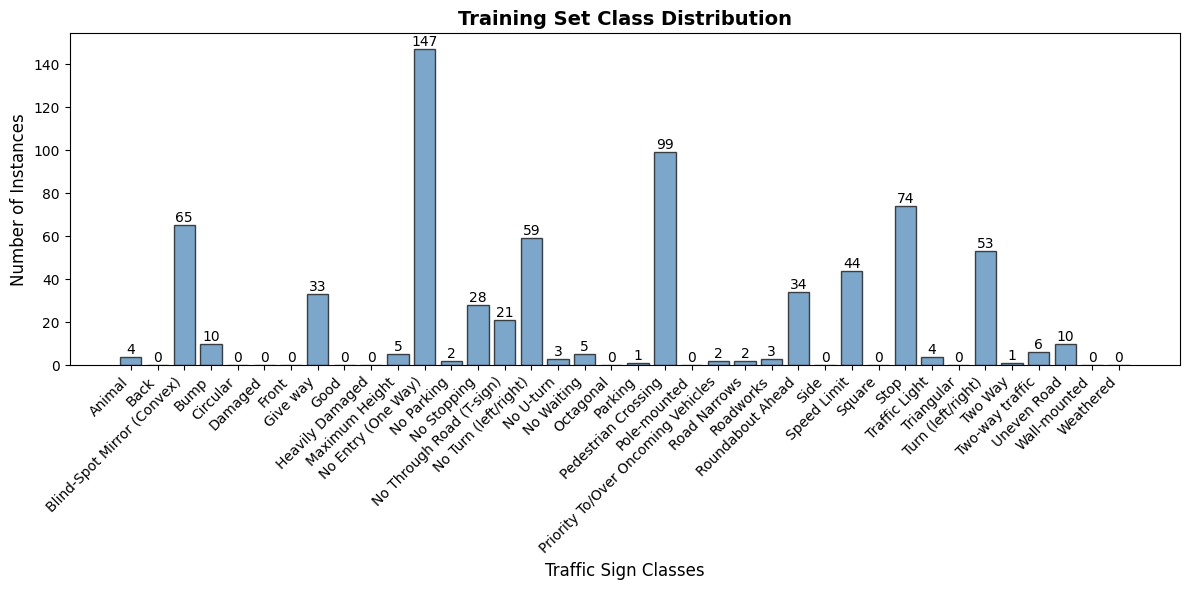

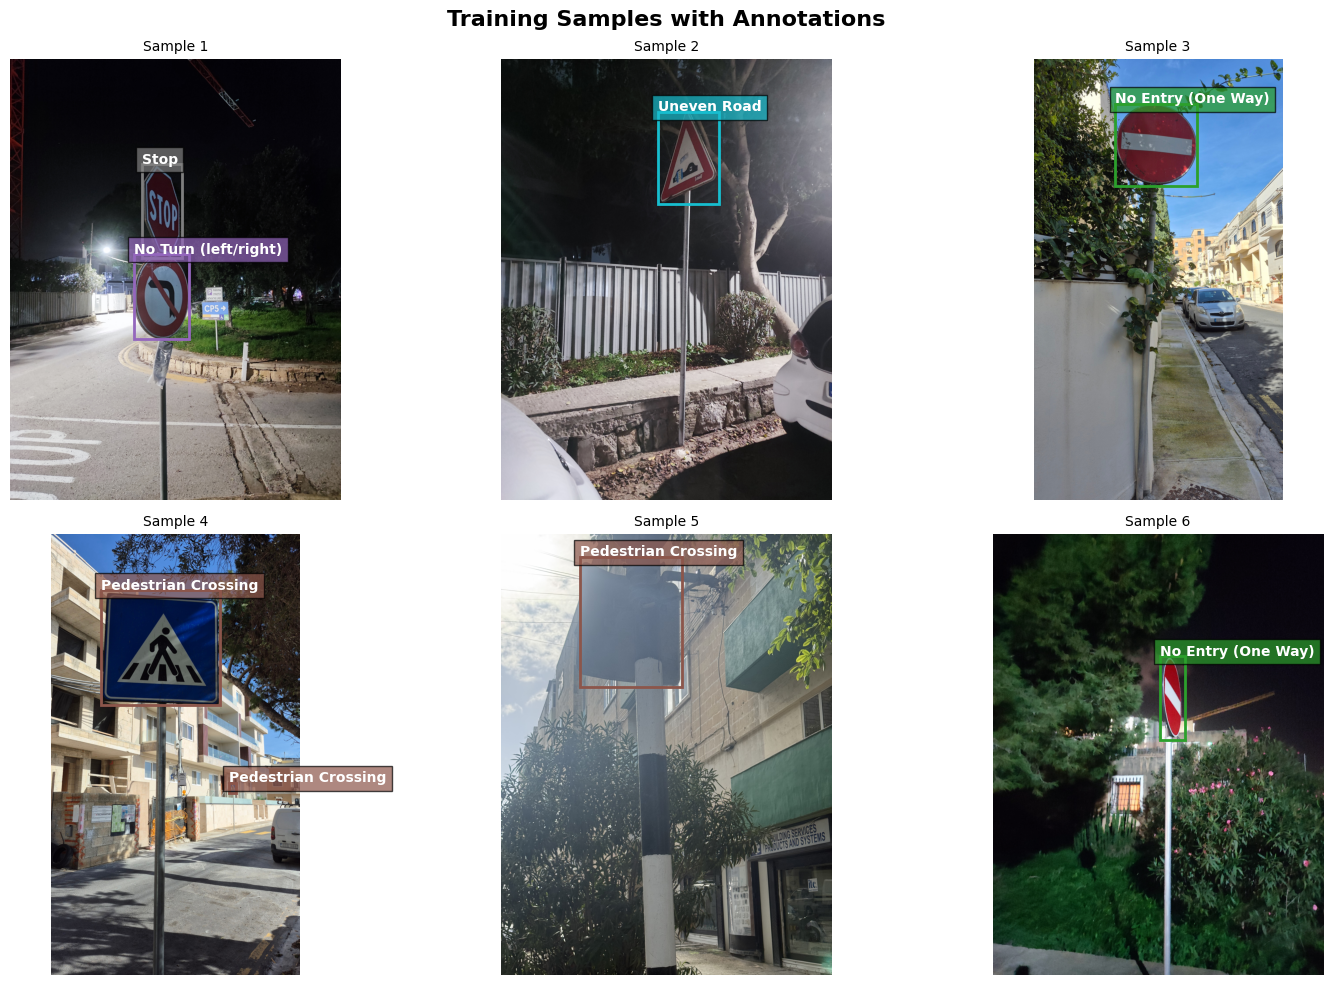

Class statistics: {'Animal': 4, 'Back': 0, 'Blind-Spot Mirror (Convex)': 65, 'Bump': 10, 'Circular': 0, 'Damaged': 0, 'Front': 0, 'Give way': 33, 'Good': 0, 'Heavily Damaged': 0, 'Maximum Height': 5, 'No Entry (One Way)': 147, 'No Parking': 2, 'No Stopping': 28, 'No Through Road (T-sign)': 21, 'No Turn (left/right)': 59, 'No U-turn': 3, 'No Waiting': 5, 'Octagonal': 0, 'Parking': 1, 'Pedestrian Crossing': 99, 'Pole-mounted': 0, 'Priority To/Over Oncoming Vehicles': 2, 'Road Narrows': 2, 'Roadworks': 3, 'Roundabout Ahead': 34, 'Side': 0, 'Speed Limit': 44, 'Square': 0, 'Stop': 74, 'Traffic Light': 4, 'Triangular': 0, 'Turn (left/right)': 53, 'Two Way': 1, 'Two-way traffic': 6, 'Uneven Road': 10, 'Wall-mounted': 0, 'Weathered': 0}


In [6]:
import matplotlib.patches as patches
from pathlib import Path

def PlotClassDistribution(yamlPath: str):
    with open(yamlPath, 'r') as f:
        data = yaml.safe_load(f)
    
    classCounts = defaultdict(int)
    trainLabels = list(Path(yamlPath).parent.glob('labels/train/*.txt'))
    
    for labelFile in trainLabels:
        with open(labelFile, 'r') as f:
            for line in f:
                if line.strip():
                    classId = int(line.split()[0])
                    classCounts[classId] += 1
    
    names = data.get('names', {})
    classes = [names.get(i, f"Class {i}") for i in range(len(names))]
    counts = [classCounts.get(i, 0) for i in range(len(names))]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(classes, counts, color='steelblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Traffic Sign Classes', fontsize=12)
    plt.ylabel('Number of Instances', fontsize=12)
    plt.title('Training Set Class Distribution', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f"{Config.OutputDir}/class_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    return dict(zip(classes, counts))

def PlotSampleImages(numSamples: int = 6):
    trainImgDir = Path(Config.YoloOutputDir) / "images/train"
    trainLabelDir = Path(Config.YoloOutputDir) / "labels/train"
    
    images = list(trainImgDir.glob("*.jpg"))[:numSamples]
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    with open(Path(Config.YoloOutputDir) / "dataset.yaml", 'r') as f:
        names = yaml.safe_load(f).get('names', {})
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(names)))
    
    for idx, imgPath in enumerate(images):
        if idx >= len(axes): break
        
        img = Image.open(imgPath)
        ax = axes[idx]
        ax.imshow(img)
        
        labelFile = trainLabelDir / (imgPath.stem + ".txt")
        if labelFile.exists():
            with open(labelFile, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    classId = int(parts[0])
                    cx, cy, w, h = map(float, parts[1:])
                    
                    imgW, imgH = img.size
                    x1 = (cx - w/2) * imgW
                    y1 = (cy - h/2) * imgH
                    boxW = w * imgW
                    boxH = h * imgH
                    
                    rect = patches.Rectangle((x1, y1), boxW, boxH, 
                                           linewidth=2, edgecolor=colors[classId], 
                                           facecolor='none', label=names.get(classId, str(classId)))
                    ax.add_patch(rect)
                    
                    ax.text(x1, y1-5, names.get(classId, str(classId)), 
                           color='white', fontsize=10, weight='bold',
                           bbox=dict(facecolor=colors[classId], alpha=0.7))
        
        ax.axis('off')
        ax.set_title(f"Sample {idx+1}", fontsize=10)
    
    plt.suptitle("Training Samples with Annotations", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{Config.OutputDir}/sample_images.png", dpi=300, bbox_inches='tight')
    plt.show()

print("Generating dataset visualizations...")
stats = PlotClassDistribution(Path(Config.YoloOutputDir) / "dataset.yaml")
PlotSampleImages()
print(f"Class statistics: {stats}")

#### Step 9A 

Load trained YOLO weights (defines `model`)


In [9]:
from pathlib import Path
from ultralytics import YOLO

rootDir = Path(".")

preferred = [
    rootDir / "outputs/yolo_detection/sign_detection/weights/best.pt",
    rootDir / "outputs/yolo_detection/sign_detection/weights/last.pt",
    rootDir / "runs/detect/sign_detection/weights/best.pt",
    rootDir / "runs/detect/sign_detection/weights/last.pt",
]

weightPath = next((p for p in preferred if p.exists()), None)

if weightPath is None:
    candidates = list(rootDir.rglob("best.pt")) + list(rootDir.rglob("last.pt"))
    weightPath = max(candidates, key=lambda p: p.stat().st_mtime) if candidates else None

if weightPath is None:
    raise FileNotFoundError("No trained weights found (best.pt/last.pt). Train first or point to the correct weights path.")

model = YOLO(str(weightPath))

names = getattr(model, "names", {})
classNames = [names[k] for k in sorted(names)] if isinstance(names, dict) else list(names) if isinstance(names, (list, tuple)) else []
print(f"Loaded weights: {weightPath}")
print(f"Classes: {len(classNames)}")
print(classNames[:20])


Loaded weights: runs/detect/outputs/yolo_detection/sign_detection/weights/best.pt
Classes: 38
['Animal', 'Back', 'Blind-Spot Mirror (Convex)', 'Bump', 'Circular', 'Damaged', 'Front', 'Give way', 'Good', 'Heavily Damaged', 'Maximum Height', 'No Entry (One Way)', 'No Parking', 'No Stopping', 'No Through Road (T-sign)', 'No Turn (left/right)', 'No U-turn', 'No Waiting', 'Octagonal', 'Parking']


# Step 9B

Evaluation & Statistics (mAP / Precision / Recall + CM + PR curve)

Using dataset YAML: data/yolo_detection/dataset.yaml
Running validation to calculate statistics...
Ultralytics 8.4.9 🚀 Python-3.11.14 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1660, 5748MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5959.9±817.1 MB/s, size: 3653.2 KB)
val: Scanning /home/ataru/Documents/ImageDetection/ARI3129-SignDetectors-Classifiers/2aYolo/ARI3129-SignDetectors-Classifiers/data/yolo_detection/labels/val.cache... 121 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 121/121 42.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.2it/s 6.4s0.2s4
                   all        121        184      0.605      0.452      0.433      0.373
                Animal          3          3      0.729          1       0.83        0.7
Blind-Spot Mirror (Convex)         19         20      0.867       0.75      0.766      0.705
                  Bump          3          3          0          0     0.0

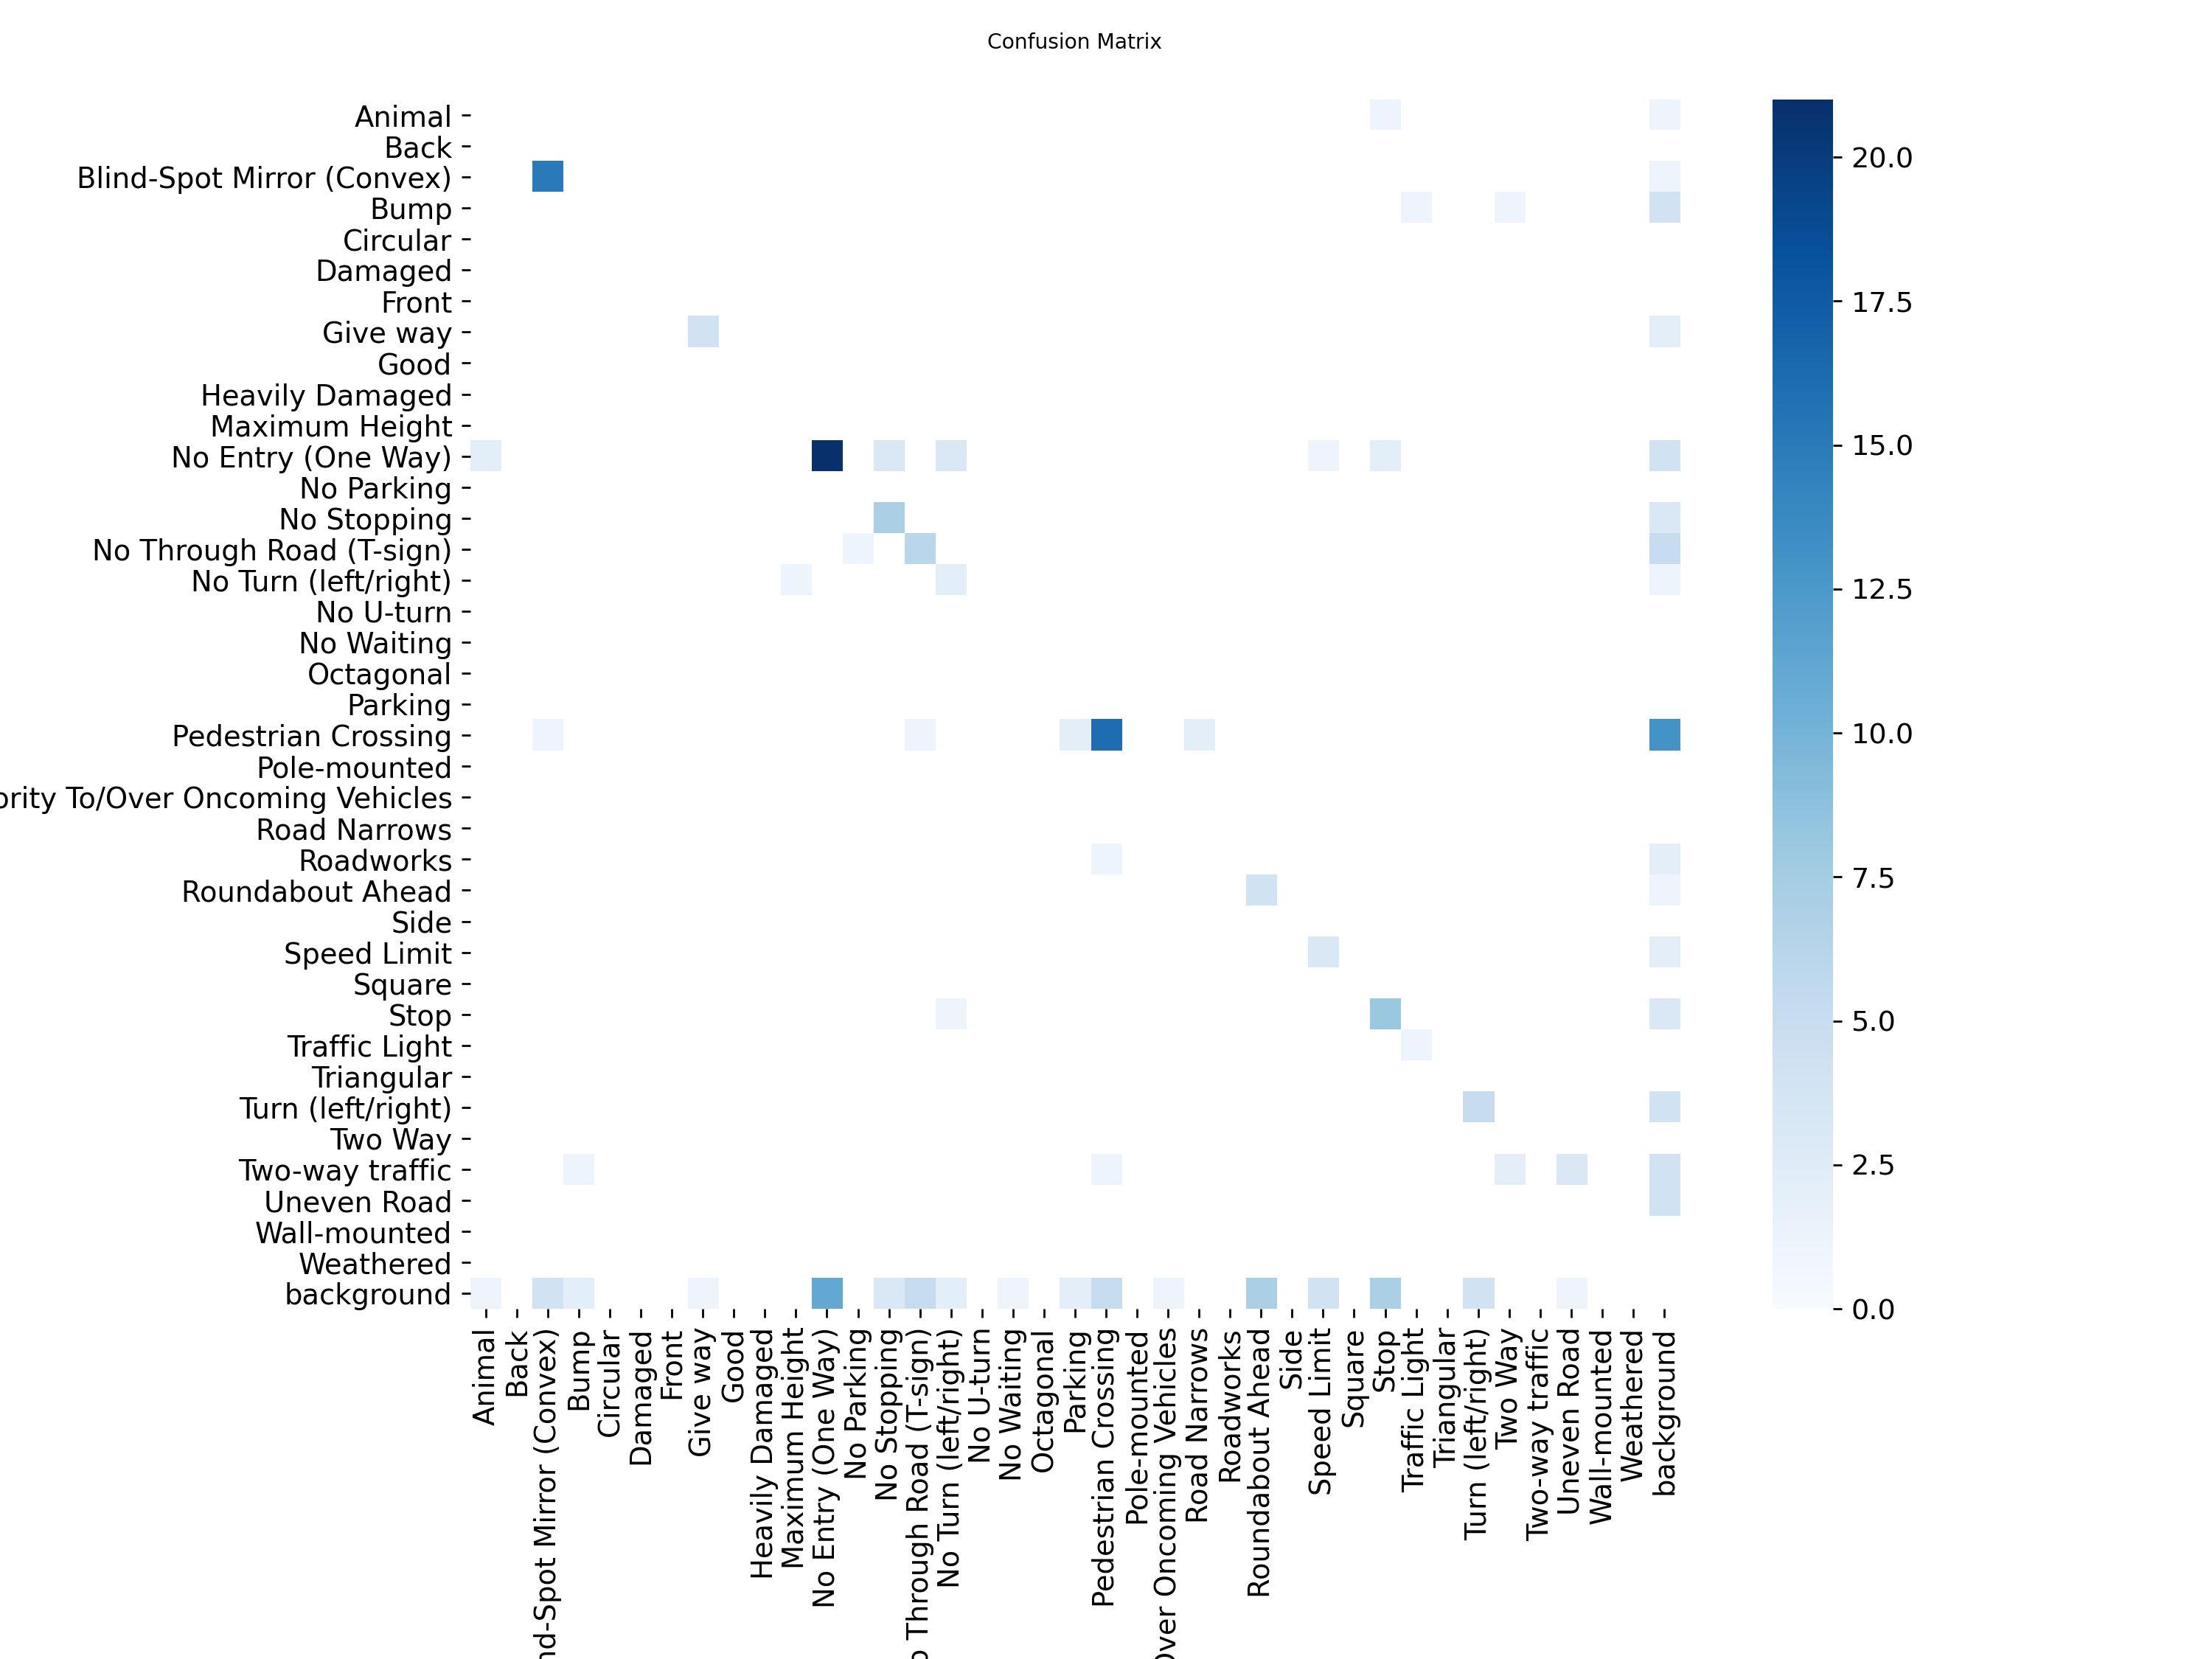


--- Precision-Recall Curve ---
PR curve image not found in: /home/ataru/Documents/ImageDetection/ARI3129-SignDetectors-Classifiers/2aYolo/ARI3129-SignDetectors-Classifiers/runs/detect/val3


In [ ]:
from pathlib import Path
from IPython.display import Image, display

if "model" not in globals():
    raise NameError("`model` is not defined. Run Step 9A first.")

if "classNames" not in globals() or not classNames:
    names = getattr(model, "names", {})
    classNames = [names[k] for k in sorted(names)] if isinstance(names, dict) else list(names) if isinstance(names, (list, tuple)) else []

rootDir = Path(".")

preferredYaml = [
    rootDir / "data/yolo_detection/dataset.yaml",
    rootDir / "data/yolo_detection/dataset.yml",
    rootDir / "dataset.yaml",
    rootDir / "dataset.yml",
]

yamlPath = next((p for p in preferredYaml if p.exists()), None)

if yamlPath is None:
    candidates = [p for p in rootDir.rglob("*.yaml")] + [p for p in rootDir.rglob("*.yml")]
    candidates = [p for p in candidates if "dataset" in p.name.lower()]
    yamlPath = max(candidates, key=lambda p: p.stat().st_mtime) if candidates else None

if yamlPath is None:
    raise FileNotFoundError("Could not find a dataset YAML. Expected something like data/yolo_detection/dataset.yaml")

print(f"Using dataset YAML: {yamlPath}")

print("Running validation to calculate statistics...")
metrics = model.val(data=str(yamlPath), split="val")

print("\n--- Key Statistics ---")
print(f"mAP50 (Mean Average Precision @ 0.5): {metrics.box.map50:.4f}")
print(f"mAP50-95 (Mean Average Precision @ 0.5:0.95): {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

print("\n--- Per-Class Performance (mAP50-95) ---")
maps = getattr(metrics.box, "maps", [])
for i, className in enumerate(classNames):
    if i < len(maps):
        print(f"{className}: {maps[i]:.4f}")
    else:
        print(f"{className}: N/A (No instances in validation set)")

saveDir = Path(str(getattr(metrics, "save_dir", "")))

print("\n--- Confusion Matrix ---")
shown = False
for fname in ["confusion_matrix.png", "confusion_matrix_normalized.png"]:
    p = saveDir / fname
    if p.exists():
        display(Image(filename=str(p)))
        shown = True
        break
if not shown:
    print(f"Confusion matrix image not found in: {saveDir}")

print("\n--- Precision-Recall Curve ---")
shown = False
for fname in ["PR_curve.png", "pr_curve.png", "P_curve.png", "R_curve.png"]:
    p = saveDir / fname
    if p.exists():
        display(Image(filename=str(p)))
        shown = True
        break
if not shown:
    print(f"PR curve image not found in: {saveDir}")
